In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression
%config InlineBackend.figure_format = "retina"
%matplotlib notebook

In [2]:
df = sns.load_dataset("tips")
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<IPython.core.display.Javascript object>


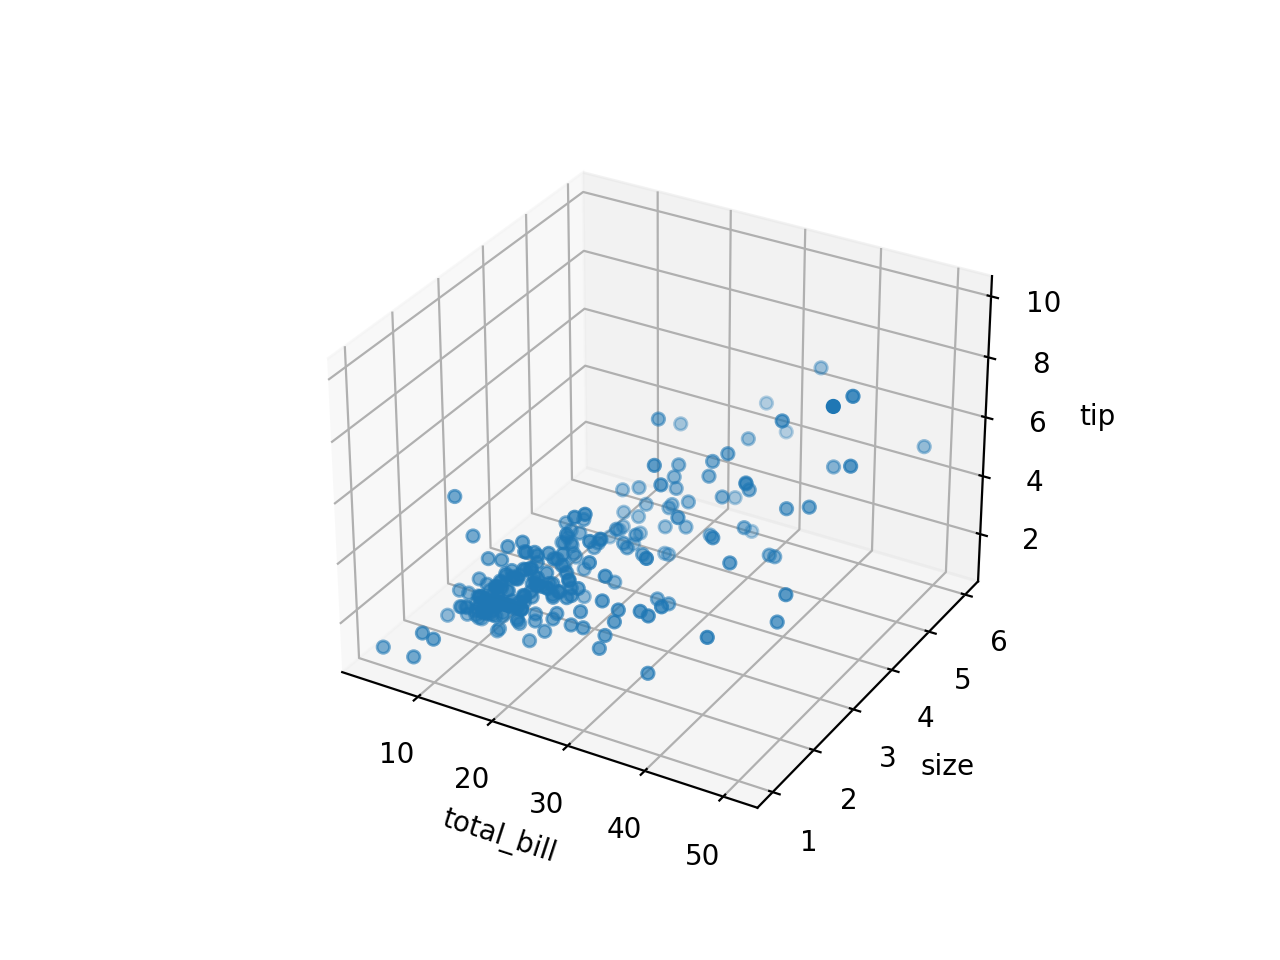

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter("total_bill", "size", "tip", data=df)
ax.set(xlabel="total_bill", ylabel="size", zlabel="tip");
# ax.set_box_aspect(None, zoom=.8)

In [4]:
X, y = df[["total_bill", "size"]], df["tip"]

In [5]:
fit = LinearRegression(fit_intercept=False).fit(X, y)
w = fit.coef_
w

array([0.1007119 , 0.36209717])

<IPython.core.display.Javascript object>


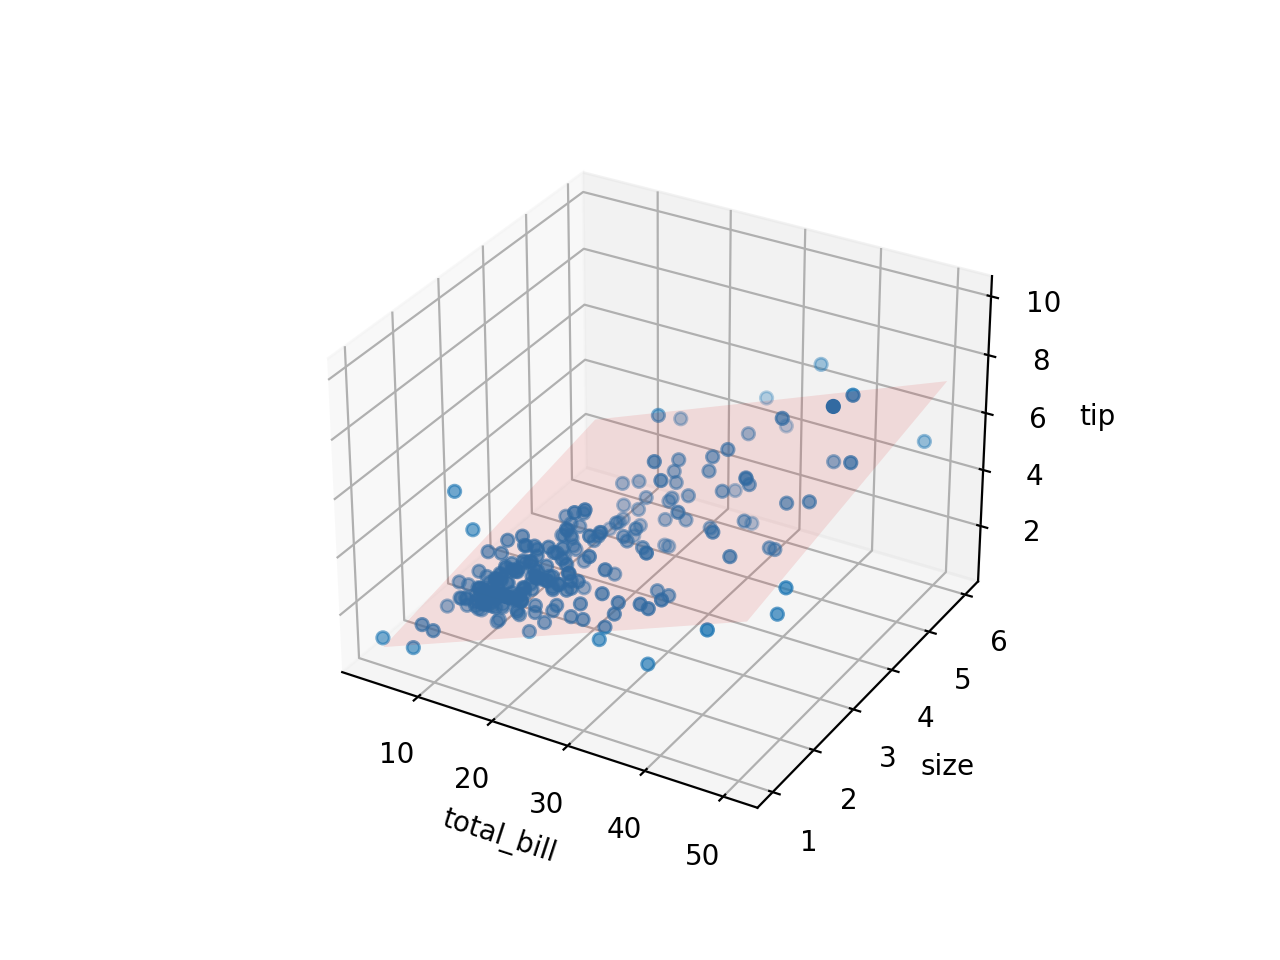

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter("total_bill", "size", "tip", data=df)
ax.set(xlabel="total_bill", ylabel="size", zlabel="tip")

xx, yy = np.meshgrid([df["total_bill"].min(), df["total_bill"].max()], [df["size"].min(), df["size"].max()])
zz = w[0] * xx + w[1] * yy
ax.plot_surface(xx, yy, zz, color="r", alpha=.1);